In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# Random Groups, Target Encode all Levels
Make random groups to match NAICS counts.   Then separately do the "regular" target encoding for each level of the hierarchy

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
# Hierarchical encoder on one feature is just regular target encoding
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder 

In [6]:
sg_plot.plot_defaults()

## Import Processed Datasets

In [7]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [8]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [9]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [10]:
naics_loans = pd.read_parquet(Path(setup.temp_path).joinpath('42_DATA_naics_groups_loans.parquet'))

In [11]:
sba_loans = sba_loans.merge(naics_loans.drop(columns=['dset', 'dset_naics_holdout', 'NAICS'],
                                             errors='ignore'),
                            on=['LoanNr_ChkDgt'])

##### Comparison metrics

In [12]:
metrics_base = pd.read_csv(Path(setup.temp_path).joinpath('A42_REPORT_metrics.csv'))

In [13]:
# Target-Thresh Encoding
metrics_tc = pd.read_csv(Path(setup.temp_path).joinpath('A43_REPORT_metrics.csv'))

In [14]:
# Target+Count Encoding
metrics_tt = pd.read_csv(Path(setup.temp_path).joinpath('A44_REPORT_metrics.csv'))

In [15]:
# Regular, non-hierarchical target encoding, for a horizontal reference line
metrics_tenc = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

## Encode NAICS and Groups

In [54]:
def get_metrics(data, enc_features = ['NAICS', 'NAICS_sector'],
               save_info = False):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:HierarchicalEncoder(lambda_k = setup.selected_lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[[f]], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[[f]]) for f in enc_features],
                    axis=1, keys=enc_features)
    
    predictor_features = setup.predictor_features + list(enc_val.columns)
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), 
                       enc_val], axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Save info for Shapley (optional)
    if save_info:
        pd.concat([data[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']] \
               .drop(columns=enc_val.columns, errors='ignore'), enc_val], axis = 1) \
            .to_parquet(Path(setup.temp_path).joinpath('A45_DATA_encodings.parquet'))
        with open(Path(setup.temp_path).joinpath('A45_DATA_features_predict.pkl'), 'wb') as fout:
            pickle.dump(predictor_features, fout)
        xgb_model.save_model(Path(setup.temp_path).joinpath('A45_MODEL_xgboost.json'))
        
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [55]:
# Hierarchical encode from different levels
enc_features = sorted([c for c in sba_loans.columns if c.startswith('rgrp')], reverse=True)
enc_features

['rgrp_834', 'rgrp_354', 'rgrp_106', 'rgrp_020']

In [56]:
# Hierarchical encode from different levels
feature_sets = [['NAICS'] + enc_features[i:] \
              for i in range(len(enc_features))]
feature_sets

[['NAICS', 'rgrp_834', 'rgrp_354', 'rgrp_106', 'rgrp_020'],
 ['NAICS', 'rgrp_354', 'rgrp_106', 'rgrp_020'],
 ['NAICS', 'rgrp_106', 'rgrp_020'],
 ['NAICS', 'rgrp_020']]

In [57]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
save_info = True # Save the first model and related info
for this_set in feature_sets:
    this_pred, this_met = get_metrics(sba_loans, this_set, save_info = save_info)
    this_pred['c'] = this_set[1]
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = this_set[1]
    metrics_df = pd.concat([metrics_df, this_met])
    save_info = False

In [58]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.660575,0.449470,0.337249,0.673620,0.384075,0.729280,0.0,rgrp_834
0,test,0.662404,0.450291,0.338529,0.672216,0.384198,0.729239,0.0,rgrp_354
0,test,0.661473,0.449705,0.337802,0.672476,0.384712,0.729310,0.0,rgrp_106
0,test,0.659879,0.450221,0.337237,0.677054,0.383074,0.728769,0.0,rgrp_020


In [59]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.640764,0.423116,0.298731,0.724981,0.348281,0.729993,1.0,rgrp_834
1,test,0.641764,0.421162,0.298112,0.717198,0.347171,0.729189,1.0,rgrp_354
1,test,0.640503,0.422653,0.298414,0.724135,0.348378,0.730269,1.0,rgrp_106
1,test,0.638505,0.422835,0.297825,0.728703,0.347102,0.729605,1.0,rgrp_020


In [60]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A45_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A45_REPORT_metrics.csv'), index=True)

## Comparison Plot

In [61]:
col_map = {f:int(f.replace('rgrp_', '')) for f in enc_features}
label_k = sorted([int(c) for c in col_map.values()])

In [62]:
col_map

{'rgrp_834': 834, 'rgrp_354': 354, 'rgrp_106': 106, 'rgrp_020': 20}

In [63]:
metrics_sum = metrics_df[~metrics_df['dset_naics_holdout'].isna()].copy()
metrics_sum['k'] = metrics_sum['c'].apply(lambda x: col_map[x]).astype('int')

In [64]:
metrics_base_sum = metrics_base[~metrics_base['dset_naics_holdout'].isna()].copy()
metrics_base_sum['k'] = metrics_base_sum['c'].apply(lambda x: col_map[x]).astype('int')

In [65]:
metrics_tc_sum = metrics_tc[~metrics_tc['dset_naics_holdout'].isna()].copy()
metrics_tc_sum['k'] =metrics_tc_sum['c'].apply(lambda x: col_map[x]).astype('int')

In [66]:
metrics_tt_sum = metrics_tt[~metrics_tt['dset_naics_holdout'].isna()].copy()
metrics_tt_sum['k'] =metrics_tt_sum['c'].apply(lambda x: col_map[x]).astype('int')

In [67]:
metrics_sum_dict = {'mhier':metrics_base_sum,
                    'menc_all': metrics_sum,
                    'tc': metrics_tc_sum,
                    'tt': metrics_tt_sum}

In [68]:
# Reference lines
hline_test = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 0) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
hline_ho = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 1) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
print(f'Regular target encoding test result: {hline_test}; holdout {hline_ho}')

Regular target encoding test result: 0.382950251407698; holdout 0.346336505844941


In [69]:
def make_plot(sum_dict, holdout_val, hline_val, yfeature, ylabel,
              title = None, titlesize = 16, legendsize = 12,
              ax = None):
    m_dict = {k: v[v['dset_naics_holdout'] == holdout_val] for k, v in sum_dict.items()}
    return sg_plot.curve_compare_hline(m_dict, hline_val=hline_val,
                                       style_dict =setup.model_label_styles,
                                       color_dict = setup.model_label_colors,
                                       label_dict = setup.model_label_dict,
                                       xfeature = 'k',
                                       yfeature = yfeature,
                                       xlabel='Group Count (k)',
                                       ylabel = ylabel,
                                       titlesize = titlesize,
                                       legendsize = legendsize,
                                       title = title,
                                      ax=ax)

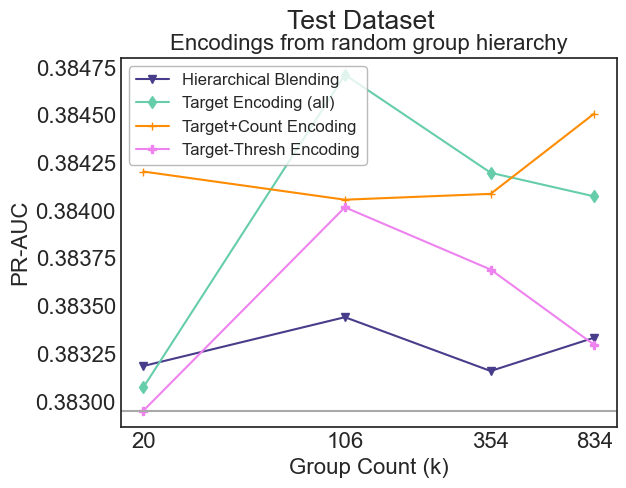

In [70]:
fig = make_plot(metrics_sum_dict, 0, hline_test,
                yfeature = 'average_precision_score',
                ylabel='PR-AUC',
                title='Encodings from random group hierarchy')
fig.suptitle('Test Dataset')
#plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.9, 0.4))
plt.gca().set_xticks(label_k)
plt.gca().set_xticklabels(label_k)
fig.savefig(Path(setup.temp_path).joinpath('A45_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

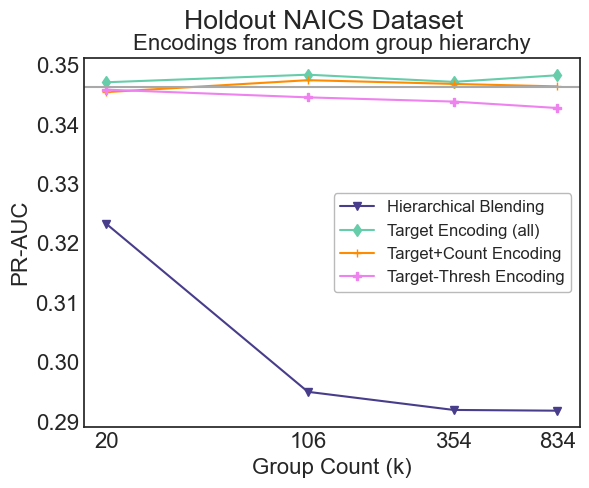

In [71]:
fig = make_plot(metrics_sum_dict, 1, hline_ho,
                yfeature = 'average_precision_score',
                ylabel='PR-AUC',
                title='Encodings from random group hierarchy')
fig.suptitle('Holdout NAICS Dataset')
#plt.gca().legend(frameon=True, fontsize=12).set_bbox_to_anchor((0.9, 0.4))
plt.gca().set_xticks(label_k)
plt.gca().set_xticklabels(label_k)
fig.savefig(Path(setup.temp_path).joinpath('A45_PLOT_compare_base_ho.png'),
            bbox_inches='tight')

##### Combined plot

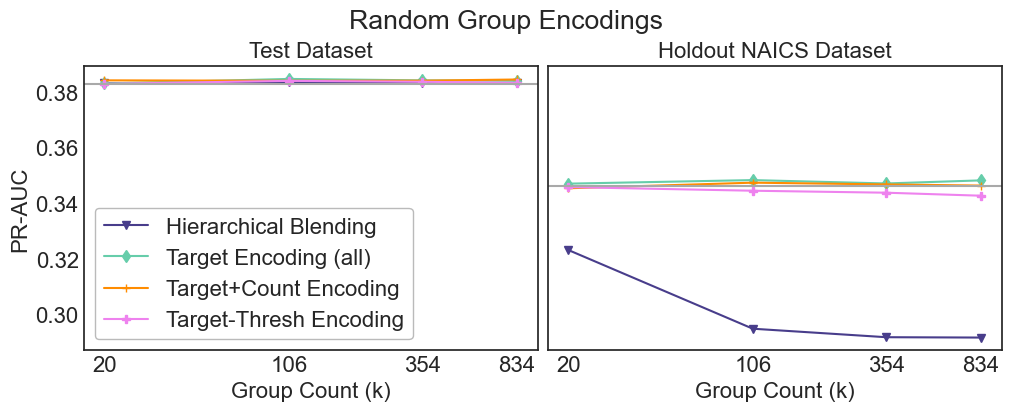

In [72]:
# Combined plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,
                      figsize = (10,4), layout='constrained')
make_plot(metrics_sum_dict, 0, hline_test,
                yfeature = 'average_precision_score',
                ylabel='PR-AUC',
                title='Test Dataset',
         ax=ax[0],
         legendsize=16)
make_plot(metrics_sum_dict, 1, hline_ho,
                yfeature = 'average_precision_score',
                ylabel='PR-AUC',
                title='Holdout NAICS Dataset',
         ax=ax[1])
ax[0].set_xticks(label_k)
ax[0].set_xticklabels(label_k)
ax[1].set_xticks(label_k)
ax[1].set_xticklabels(label_k)
ax[1].legend().set_visible(False)
fig.suptitle('Random Group Encodings')
fig.savefig(Path(setup.temp_path).joinpath('A45_PLOT_compare_base_combined.png'),
            bbox_inches='tight')

## Train Comparison
Same plots, relative to train PR-AUC

In [73]:
# Reference line for standard target encoding
hline_train = metrics_tenc[(metrics_tenc['dset'] == 'train') &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
delta_target_test = hline_test - hline_train
delta_target_ho =  hline_ho -  hline_train      
print(f'Regular target encoding train deltas: {delta_target_test}; holdout {delta_target_ho}')

Regular target encoding train deltas: -0.00950607699637157; holdout -0.046119822559128554


In [74]:
def get_delta(m_sum, m):
    m_delta = m_sum \
        .merge(m[m['dset'] == 'train'][['c', 'average_precision_score']] \
               .rename(columns={'average_precision_score':'base_prauc'}),
           on='c')
    m_delta['delta'] = m_delta['average_precision_score'] - m_delta['base_prauc'] 
    return m_delta

In [75]:
metrics_base_delta = get_delta(metrics_base_sum, metrics_base)
metrics_sum_delta = get_delta(metrics_sum, metrics_df)
metrics_tt_delta = get_delta(metrics_tt_sum, metrics_tt)
metrics_tc_delta = get_delta(metrics_tc_sum, metrics_tc)

In [76]:
metrics_delta_dict = {'mhier':metrics_base_delta,
                    'menc_all': metrics_sum_delta,
                    'tc': metrics_tt_delta,
                    'tt': metrics_tc_delta}

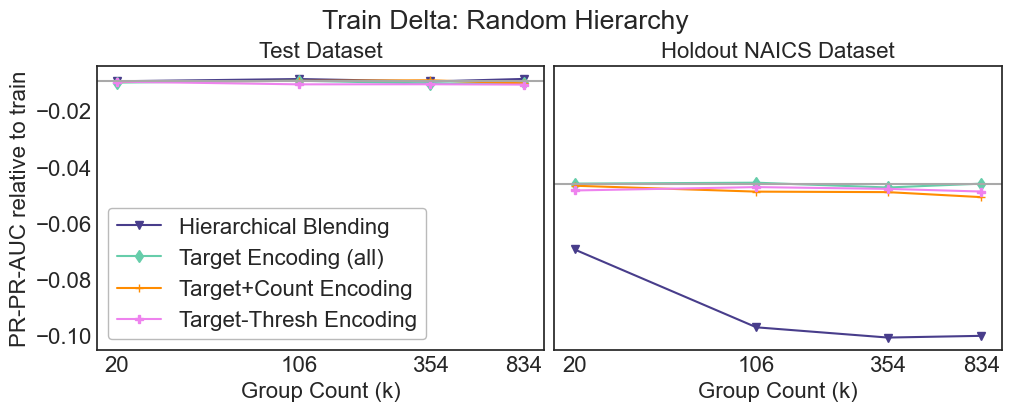

In [77]:
# Combined plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,
                      figsize = (10,4), layout='constrained')
make_plot(metrics_delta_dict, 0, delta_target_test,
                yfeature = 'delta',
                ylabel='PR-PR-AUC relative to train',
                title='Test Dataset',
         ax=ax[0],
         legendsize=16)
make_plot(metrics_delta_dict, 1, delta_target_ho,
                yfeature = 'delta',
                ylabel='PR-AUC',
                title='Holdout NAICS Dataset',
         ax=ax[1])
ax[0].set_xticks(label_k)
ax[0].set_xticklabels(label_k)
ax[1].set_xticks(label_k)
ax[1].set_xticklabels(label_k)
ax[1].legend().set_visible(False)
fig.suptitle('Train Delta: Random Hierarchy')
fig.savefig(Path(setup.temp_path).joinpath('A45_PLOT_compare_train_deltas.png'),
            bbox_inches='tight')